<a href="https://colab.research.google.com/github/lblogan14/Python_Deep_Learning/blob/master/ch4_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Convolutional neural networks connect neurons, which only correspond to neighboring pixels of the image and use parameter sharing.

#Convolutional Layers
The convolutional layer consists of a set of filters (a.k.a kernels, feature detectors), where each filter is applied across all areas of the input data. Each input neuron represents the color intensity of a pixel. Each input neuron is associated with a single weight of the filter. Thus, a 3x3 filter has nine weights. The output of the filter is a weighted sum of its input and is used to highlight a specific feature in the input. The group of nearby neurons which participate in the input are called the receptive field. \\
**Parameter sharing**: When "sliding" the kernel, the weights of the filter do not change across the image. The same filter weights are used to compute the activations of all output neurons, each time with a different set of input neurons.

An output slice can receive input from:
* all input slices, which is standard for convolutional layers. A single output slice is a case of the n-to-1 relationship. With multiple output slices, the relation becomes n-to-m, and each input slice contributes to the output of each output slice.
* a single input slice. This is known as **depthwise convolution**. A filter is applied over a single input slice to produce a single output slice. This is a case of one-to-one relation. Also, a **channel multiplier** (an integer m) can be specified, where m filters are applied over a single output slice to produce m output slices. This is a case of 1-to-m relation. The total number of output slices is n*m.

If the width and the height of the filter are $F_w$ and $F_h$, the depth of the input volume is $D$, and the depth of the output volume is $M$. Then, the total number of weights $W$ in a convolutional layer is
$$W=(D*F_w*F_h+1)*M$$
For example, if there are three slices and four 5x5 filters, then the convolutional layer will have a total of (3x5x5+1)*4=304 weights, and four output slices (output volume with depth of 4), one bias per slice. The filter for each output slice will have three 5x5 filter patches for each of the three input slices and one bias for a total of 3x5x5+1=76 weights. The combination of the output maps is called **output volume** with a **depth** of four.

The fully-connected layer can be seen as a special case of convolutional layer with input volume of depth 1, filters with the same size as the size of the input, and a total number of filters, equal to the number of output neurons.

#CNN Example

In [0]:
import numpy as np

In [0]:
def conv(image, im_filter):
  '''
  :param image: grayscale image as a 2-dimensional numpy array
  :param im_filter: 2-dimensional numpy array
  '''

  # input dimensions
  height = image.shape[0]
  width = image.shape[1]

  # output image with reduced dimensions
  im_c = np.zeros((height - len(im_filter) + 1,
                   width - len(im_filter + 1)))
  
  # iterate over all rows and columns
  for row in range(len(im_c)):
    for col in range(len(im_c[0])):
      # apply the filter
      for i in range(len(im_filter)):
        for j in range(len(im_filter[0])):
          im_c[row, col] += image[row + i, col + j] * im_filter[i][j]

  # fix out-of-bound values
  im_c[im_c > 255] = 255
  im_c[im_c < 0] = 0

  # plot images for comparison
  import matplotlib.pyplot as plt
  import matplotlib.cm as cm

  plt.figure()
  plt.imshow(image, cmap=cm.Greys_r)
  plt.show()

  plt.imshow(im_c, cmap=cm.Greys_r)
  plt.show()

The `conv` function applies the convolution across the image.

1.   compute the output image size which is used to instantiate the output image `im_c`
2.   iterate over all pixels of the image, applying filter at each location
3.   check if any value out of the `[0, 255]` interval
4.   display input and output



Download an image and convert to grayscale

In [0]:
import requests
from PIL import Image
from io import BytesIO

In [0]:
# download an image
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Commander_Eileen_Collins_-_GPN-2000-001177.jpg/382px-Commander_Eileen_Collins_-_GPN-2000-001177.jpg?download'
resp = requests.get(url)
image_rgb = np.asarray(Image.open(BytesIO(resp.content)).convert('RGB'))

# convert to grayscale
image_grayscale = np.mean(image_rgb, axis=2, dtype=np.uint)

Apply different filters across the image.

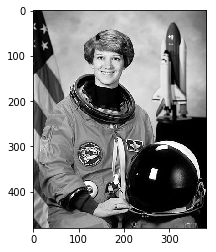

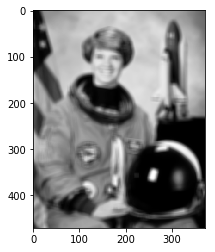

In [7]:
# blur filter
blur = np.full([10, 10], 1./100)
conv(image_grayscale, blur)

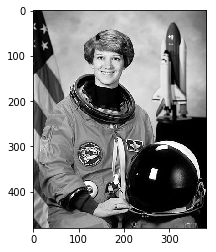

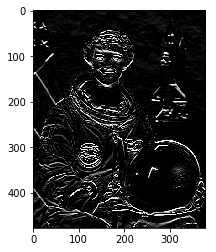

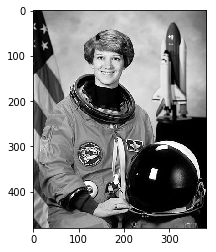

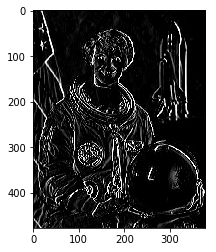

In [10]:
# sobel filters
sobel_x = np.array([[-1, -2, -1],
           [0, 0, 0],
           [1, 2, 1]])
conv(image_grayscale, sobel_x)

sobel_y = np.array([[-1, 0, 1],
           [-2, 0, 2],
           [-1, 0, 1]])
conv(image_grayscale, sobel_y)

#Stride and padding in convolutional layers
The stride is used to slide the filter multiple positions. By using a stride larger than 1, the size of the output slice is reduced.

The formula for the output size:

```
((width - filter_w)/stride_w + 1, (height - filter_h)/stride_h + 1)
```

For example, the output size of a square slice generated by a 28x28 input image, convolved with a 3x3 filter with stride 1, would be 28-3+1=26, but with stride 2, it would be (28-3)/2+1=13.

The main effect of the larger stride is an increase in the receptive field of the output neurons. If stride 2 is used, the size of the output slice will be four times smaller than the input. One output neuron will cover area, which is four times larger, compared to the input neurons.

Use **padding** to control the size of the output. Padding the edges of the input slice with rows and columns of zeros before the convolution operation so the output will have the same dimensions as the input. Let the size of the input slice be $I(I_w,I_h)$, the size of the filter $F=F(F_w,F_h)$, the stride $S=(S_w,S_h)$, and the padding $P=(P_w,P_h)$. Thus, the size $O=(O_w,O_h)$ of the output slice is given by
$$O_w=\frac{I_w+2P_w-F_w}{S_w}+1$$
$$O_h=\frac{I_h+2P_h-F_h}{S_h}+1$$


#Pooling layers
* Max pooling, takes the neuron with the highest activation value in each local receptive field, and propagates only the value forward.
* Average pooling, takes the mean value of all activation within the field.

Pooling layers are defined by 
* Stride
* Receptive field size

In practice, only two combinations are used:
* 2x2 receptive field with stride 2
* 3x3 receptive field with stride 2.

A larger value for either parameters make the network lose too much information. If the stride is 1, the size of the layer would not be smaller, neither will the receptive field increase. Let $I$ be the size of the input slice, $F$ the size of the receptive field, $S$ the size of the stride, $O$ the size of the output. Pooling layers typically don't have padding. The output size is given by:
$$O_w=\frac{I_w-F_w}{S_w}+1$$
$$O_h=\frac{I_h-F_h}{S_h}+1$$

#Structure of a Convolutional Network
* One or more convolutional layers is typically alternated with one pooling layer, so the convolutional layers can detect features at every level of the receptive field size. The aggregated receptive field size of deeper layers is larger than the ones at the beginning of the network. This allows them to capture more complex features from larger input regions. For example, a network uses 3x3 convolutions with stride 1 and 2x2 pooling with stride 2:
  * The neurons of the first convolutional layer will receive input from 3x3 pixels of the image
  * A group of 2x2 output neurons of the first layer will have a combined receptive field size of 4x4 (because of the stride)
  * This group will be combined in a single neuron of the pooling layer after the first pooling operation
  * The second convolution operation takes input from 3x3 pooling neurons. Therefore, it will receive input from a square with side 3x4=12 (or a total of 12x12=144) pixels from the input image.
* The features detected by the deepest layers are highly abstract, but not readable by humans. One or more fully-connected layers are added after the last convolutional/pooling layer to interpret those representations.
* The deeper convolutional layers ususlly have more filters (hence higher volume depth), compared to the initial ones. A feature detector in the beginning of the network works on a small receptive field. It can only detect a limited number of features, such as edges or lines, shared among all classes. On the other hand, a deeper layer would detect more complex and numerous features

#CNN with MNIST
Keras setup

In [0]:
from numpy.random import seed
from tensorflow import set_random_seed
seed(1)
set_random_seed(1)

In [12]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Flatten
from keras.utils import np_utils

Using TensorFlow backend.


In [13]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

Y_train = np_utils.to_categorical(Y_train, 10)
Y_test = np_utils.to_categorical(Y_test, 10)

11493376/11490434 [==============================] - 1s 0us/step


In [14]:
model = Sequential([
        Convolution2D(filters=32,
                      kernel_size=(3,3),
                      input_shape=(28,28,1)), # first conv layer
        Activation('relu'),
        Convolution2D(filters=32,
                      kernel_size=(3,3)), # second conv layer
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)), # maxpooling layer
        Flatten(), # flatten the output tensor
        Dense(64), # fully-connected hidden layer
        Activation('relu'),
        Dense(10), # output layer
        Activation('softmax')
])
print(model.summary())

W0830 20:30:15.651343 139708675520384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0830 20:30:15.653720 139708675520384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 20:30:15.664798 139708675520384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0830 20:30:15.701675 139708675520384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

In [15]:
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer='adadelta')

W0830 20:30:15.747656 139708675520384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0830 20:30:15.769762 139708675520384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3576: The name tf.log is deprecated. Please use tf.math.log instead.



The `optimizer` is `ADADELTA`, whcih automatically makes the learning rate larger or smaller in an inversely proportional way to the gradient.

In [16]:
model.fit(X_train, 
          Y_train, 
          batch_size=100,
          epochs=5,
          validation_split=0.1,
          verbose=1)

W0830 20:30:15.883537 139708675520384 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0830 20:30:15.975076 139708675520384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 54000 samples, validate on 6000 samples
Epoch 1/5
54000/54000 [==============================] - 10s 190us/step - loss: 1.6272 - acc: 0.8645 - val_loss: 0.0855 - val_acc: 0.9763
Epoch 2/5
54000/54000 [==============================] - 3s 57us/step - loss: 0.0515 - acc: 0.9847 - val_loss: 0.0643 - val_acc: 0.9818
Epoch 3/5
54000/54000 [==============================] - 3s 57us/step - loss: 0.0263 - acc: 0.9921 - val_loss: 0.0436 - val_acc: 0.9888
Epoch 4/5
54000/54000 [==============================] - 3s 58us/step - loss: 0.0140 - acc: 0.9954 - val_loss: 0.0490 - val_acc: 0.9887
Epoch 5/5
54000/54000 [==============================] - 3s 58us/step - loss: 0.0076 - acc: 0.9975 - val_loss: 0.0714 - val_acc: 0.9870


In [17]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test accuracy:', score[1])

10000/10000 [==============================] - 0s 44us/step
Test accuracy: 0.9867


#CNN Performance Improvement


##Data pre-processing
* **Feature scalling**: $x=\frac{x-x_{\min}}{x_{\max}-x_{\min}}$ scales all inputs in the $[0,1]$ range.
* **Standard score**: $x=\frac{x-\mu}{\sigma}$

##Regularization
* **Weight decay**: L2 regularization
$$w\rightarrow w-\eta(\nabla(J(w)-\lambda w)$$
where $\lambda$ is the weight decay coefficient

##Dropout
Dropout randomly and periodically removes some of the neurons (along
with their input and output connections) from the network.

##Data augmentation
* Rotation
* Horizontal and vertical flip
* Zoom in/out
* Crop
* Skew
* Contrast and brightness adjustment

##Batch normalization
Batch normalization noralizes the outputs of the hidden layer for each mini-batch (hence the name) in a way, which maintains its mean activation value close to 0, and its standard deviation close to 1.

#CNN with CIFAR-10
Keras setup

In [0]:
import keras
from keras.datasets import cifar10
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator

In [0]:
batch_size = 50

In [20]:
(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

Y_train = keras.utils.to_categorical(Y_train, 10)
Y_test = keras.utils.to_categorical(Y_test, 10)

170500096/170498071 [==============================] - 6s 0us/step


The CIFAR-10 dataset is normalized by dividing it to 255

Define the data augmentation:
* need to import the `ImageDataGenerator` class
* allow rotation of up to 90 degrees, horizontal flip, horizontal and vertical shift of the data
* standardize the training data (`featurewise_center` and `featurewise_std_normalization`) and call `data_generator.fit(X_train)` to compute the mean and standard deviation
* apply training standardization over the test set.

In [0]:
data_generator = ImageDataGenerator(rotation_range=90,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    featurewise_center=True,
                                    featurewise_std_normalization=True,
                                    horizontal_flip=True)
data_generator.fit(X_train)

In [0]:
# standardize the test set
for i in range(len(X_test)):
  X_test[i] = data_generator.standardize(X_test[i])

Define the network:
* three blocks of two convolutional layers (3x3 filters) and one maxpooling layer. (`padding='same'` means the output volume slices have the same dimensions as the input ones)
* perform batch normalization after each convolutional layer
* define **exponential linear unit (ELU)** activation functions
* add a single fully-connected layer after the last maxpooling layer

In [23]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(10, activation='softmax'))

W0830 20:30:49.791410 139708675520384 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2041: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0830 20:30:49.918967 139708675520384 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Because of the data augmentation, to train the network, use the `model.fit_generator` method:

In [26]:
model.fit_generator(
    generator=data_generator.flow(x=X_train,
                                  y=Y_train,
                                  batch_size=batch_size),
    steps_per_epoch=len(X_train)//batch_size,
    epochs=5,
    validation_data=(X_test, Y_test),
    workers=4)

Epoch 1/5
1000/1000 [==============================] - 30s 30ms/step - loss: 1.5408 - acc: 0.4669 - val_loss: 1.5363 - val_acc: 0.4899
Epoch 2/5
1000/1000 [==============================] - 30s 30ms/step - loss: 1.3434 - acc: 0.5263 - val_loss: 1.2902 - val_acc: 0.5594
Epoch 3/5
1000/1000 [==============================] - 29s 29ms/step - loss: 1.2317 - acc: 0.5594 - val_loss: 1.1500 - val_acc: 0.5951
Epoch 4/5
1000/1000 [==============================] - 29s 29ms/step - loss: 1.1527 - acc: 0.5939 - val_loss: 1.1009 - val_acc: 0.6211
Epoch 5/5
1000/1000 [==============================] - 30s 30ms/step - loss: 1.0937 - acc: 0.6157 - val_loss: 1.0879 - val_acc: 0.6297
